In [1]:
# Read in zip files
import fsspec
import geopandas as gpd
import intake
import numpy as np
import pandas as pd

# My utilities
import utilities
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## Load Shapefiles

In [4]:
# California counties.
ca_gdf = (
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

In [5]:
my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}").to_crs(epsg=4326))[
    ["county_name", "geometry"]
]

In [6]:
my_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Provider shapefiles
verizon = utilities.load_verizon()[["geometry"]]
att_df = utilities.load_att()[["geometry"]]

In [8]:
tmobile_df = utilities.load_tmobile()

In [9]:
tmobile_df = tmobile_df[['geometry']]

In [10]:
tmobile_df.shape, att_df.shape, verizon.shape

((424262, 1), (36, 1), (74, 1))

In [11]:
tmobile_df.crs == att_df.crs ==  verizon.crs

True

In [12]:
tmobile_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Routes - Original dataframe
* Chose agencies-routes that pop up in final df in my analysis notebook that doesn't make sense. 

In [13]:
# Loading the original routes_df with onlyh route length added
routes_df = utilities.load_unique_routes_df()

In [14]:
routes_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
]

In [16]:
routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395"
]

In [17]:
# Filter out
routes_subset = routes_df[
    routes_df["route_name"].isin(routes_wanted)
    & routes_df["agency"].isin(agency_wanted)
]

In [18]:
# Looking at the original dataframe
routes_subset.drop(columns=["geometry"])

,itp_id,route_id,route_name,agency,original_route_length
686,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation District,56918.54
902,171,13054,Edmund D. Edelman Children’s Court Shuttle,Avocado Heights/Bassett/West Valinda Shuttle,7500.92
1977,282,14,24 hour service daily,MUNI,41216.04
1984,282,22,24 hour service daily,MUNI,31275.32
1987,282,25,24 hour service daily,MUNI,29045.13
1997,282,38,24 hour service daily,MUNI,37877.14
2137,290,251,Foster City - Hillsdale Mall,SamTrans,104371.50
2138,290,251-198,Foster City - Hillsdale Mall,SamTrans,104371.50
2867,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.13


In [19]:
# Just check out one Samtrans Foster City route.
# See if the fact that 2 routes from the same agency with the same name changes the mapping
route_251 = routes_df[
    routes_df["route_name"].str.contains("Foster City")
    & routes_df["route_id"].isin(["251"])
]

In [20]:
route_251.drop(columns=["geometry"])

,itp_id,route_id,route_name,agency,original_route_length
2137,290,251,Foster City - Hillsdale Mall,SamTrans,104371.50


In [21]:
routes_subset.explore(
    "route_id",
    width=800,
    height=400,
    tooltip=["route_name", "agency", "route_id"],
    style_kwds={"weight": 6},
    legend=False,
)

## Intersection

In [22]:
def comparison(gdf_left, gdf_right):

    # Make sure both are the same crs
    gdf_left.crs = gdf_right.crs

    # Overlay - 
    overlay_df = gpd.overlay(
        gdf_left, gdf_right, how="intersection", keep_geom_type=True
    )

    # Create a new route length for portions covered by cell coverage
    overlay_df = overlay_df.assign(
        intersected_route_length=(
            overlay_df.geometry.to_crs(geography_utils.CA_StatePlane).length
        )
    )

    return overlay_df

### County

In [23]:
county_test = comparison(routes_subset, my_gdf)

In [66]:
# Original  & Intersected don't match for routes that only fall under one county!
county_test.drop(columns=["geometry"])

,itp_id,route_id,route_name,agency,original_route_length,county_name,intersected_route_length
0,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation District,56918.54,Alameda,34954.28
1,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation District,56918.54,San Francisco,21964.26
2,282,14,24 hour service daily,MUNI,41216.04,San Francisco,38256.90
3,282,22,24 hour service daily,MUNI,31275.32,San Francisco,29933.07
4,282,25,24 hour service daily,MUNI,29045.13,San Francisco,29045.13
5,282,38,24 hour service daily,MUNI,37877.14,San Francisco,37877.14
6,171,13054,Edmund D. Edelman Children’s Court Shuttle,Avocado Heights/Bassett/West Valinda Shuttle,7500.92,Los Angeles,4041.64
7,282,14,24 hour service daily,MUNI,41216.04,San Mateo,2959.14
8,290,251,Foster City - Hillsdale Mall,SamTrans,104371.50,San Mateo,63733.04
9,290,251-198,Foster City - Hillsdale Mall,SamTrans,104371.50,San Mateo,63733.04


In [25]:
county_test.explore(
    "county_name",
    width=800,
    height=400,
    tooltip=["route_name", "agency", "county_name"],
    style_kwds={"weight": 6},
    legend=False,
    color="tab20c",
)

In [26]:
# Sum up intersected_route_length to see if it adds back to the origina lroute _length
# for routes that fall in multiple counties
county_test_dissolved = county_test.dissolve(
    by=[
        "route_id",
        "agency",
        "itp_id",
    ],
    aggfunc={"intersected_route_length": "sum"},
).reset_index()

#### Check that county intersected lengths matches the original route length.
* SamTrans & Edmund D. Edelman don't fall in their respective counties.

In [27]:
m1 = county_test_dissolved.merge(
    routes_subset,
    how="inner",
    on=["route_id", "agency", "itp_id"],
)

In [28]:
m1["does_og_length_match_intersected"] = (
    m1["intersected_route_length"] / m1["original_route_length"]
)

In [29]:
m1.loc[:, ~m1.columns.str.contains("geometry|_merge|_type|itp")].sort_values(['does_og_length_match_intersected'])

,route_id,agency,intersected_route_length,route_name,original_route_length,does_og_length_match_intersected
0,13054,Avocado Heights/Bassett/West Valinda Shuttle,4041.64,Edmund D. Edelman Children’s Court Shuttle,7500.92,0.54
4,251,SamTrans,63733.04,Foster City - Hillsdale Mall,104371.50,0.61
5,251-198,SamTrans,63733.04,Foster City - Hillsdale Mall,104371.50,0.61
2,22,MUNI,29933.07,24 hour service daily,31275.32,0.96
7,582,Yosemite Area Regional Transportation System,624035.48,Mammoth Lakes HWY 120E/395,634216.13,0.98
3,25,MUNI,29045.13,24 hour service daily,29045.13,1.00
6,38,MUNI,37877.14,24 hour service daily,37877.14,1.00
8,705-240,Golden Gate Bridge Highway and Transportation District,56918.54,Oakland - San Francisco,56918.54,1.00
1,14,MUNI,41216.04,24 hour service daily,41216.04,1.00


## Cell Coverage Intersect

In [30]:
att_test = comparison(routes_subset, att_df)

In [31]:
verizon_test = comparison(routes_subset, verizon)

### Yosemite: the intersected route lengths are REALLY much greater than the original?

In [32]:
verizon_yosemite = verizon_test.loc[verizon_test['route_id']=='582']

In [33]:
verizon_yosemite.drop(columns = ['geometry'])

,itp_id,route_id,route_name,agency,original_route_length,intersected_route_length
10,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.13,83336.50
11,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.13,7391.70
12,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.13,234795.54


<AxesSubplot:>

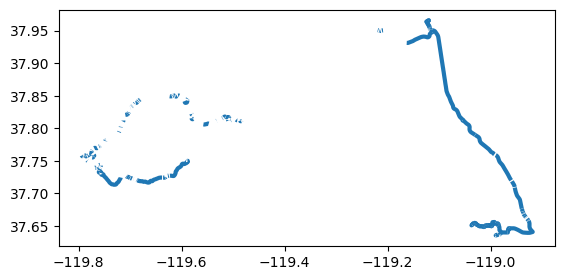

In [34]:
verizon_yosemite.plot(lw=3)

In [35]:
verizon_yosemite.intersected_route_length.sum()

325523.7400129246

### Look at Oakland-SF Golden Gate Bridge Highway and Transportation
* Skips portions of the Bay Bridge

<AxesSubplot:>

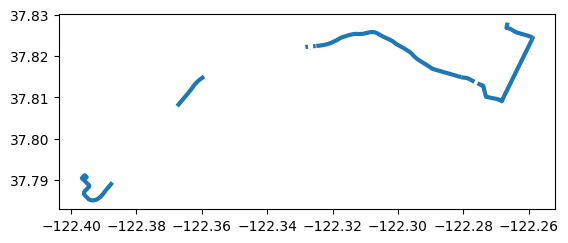

In [36]:
(verizon_test.loc[verizon_test['route_id']=='705-240']).plot(lw=3)

<AxesSubplot:>

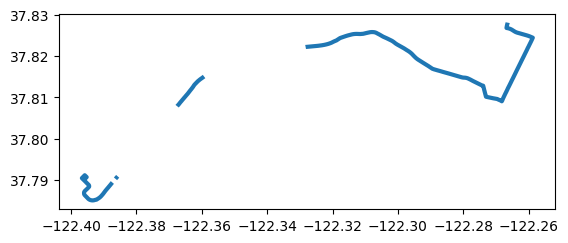

In [37]:
(att_test.loc[att_test['route_id']=='705-240']).plot(lw=3)

In [38]:
tmobile_test = comparison(routes_subset, tmobile_df)

In [39]:
def dissolve(gdf, provider: str):
    # Sum up all the intersected route lengths together
    overlay_test_dissolved = gdf.dissolve(
        by=["route_id", "agency", "itp_id", "route_name"], 
        aggfunc={"intersected_route_length": "sum"}
    ).reset_index()
    
    # Add a column for provider name
    overlay_test_dissolved["provider"] = provider
    return overlay_test_dissolved

In [40]:
att_test = dissolve(att_test, "_att")

In [41]:
verizon_test = dissolve(verizon_test, "_verizon")

In [42]:
tmobile_test = dissolve(tmobile_test, "_tmobile")

In [43]:
type(tmobile_test), type(verizon_test), type(att_test)

(geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame)

In [44]:
# Make sure crs are all the same
att_test.geometry.crs == verizon_test.geometry.crs == tmobile_test.geometry.crs

True

In [45]:
# Concat three by stacking them on top.
all_providers = pd.concat([att_test, verizon_test, tmobile_test])

In [46]:
# all_providers.drop(columns=["geometry"]).sort_values(['agency', 'route_id'])

In [47]:
# Add up all the route lengths across all 3 providers
all_providers_agg = all_providers.dissolve(
    by=["route_id", "agency", "itp_id", "route_name"], aggfunc={"intersected_route_length": "sum"}
).reset_index()

In [48]:
all_providers_agg.drop(columns=["geometry"]).sort_values(['agency', 'route_id'])

,route_id,agency,itp_id,route_name,intersected_route_length
0,13054,Avocado Heights/Bassett/West Valinda Shuttle,171,Edmund D. Edelman Children’s Court Shuttle,12123.69
8,705-240,Golden Gate Bridge Highway and Transportation District,127,Oakland - San Francisco,114506.93
1,14,MUNI,282,24 hour service daily,121976.91
2,22,MUNI,282,24 hour service daily,88894.80
3,25,MUNI,282,24 hour service daily,58942.13
6,38,MUNI,282,24 hour service daily,113631.40
4,251,SamTrans,290,Foster City - Hillsdale Mall,191195.46
5,251-198,SamTrans,290,Foster City - Hillsdale Mall,191195.46
7,582,Yosemite Area Regional Transportation System,374,Mammoth Lakes HWY 120E/395,873485.66


### Merge 
* Merge all the providers that are aggregated with the original df. 
* Intersected route length should be 3x the original one.

In [49]:
m1 = all_providers_agg.merge(
    routes_subset,
    how="inner",
    on=["route_id", "agency", "itp_id", "route_name"],
)

In [58]:
m1["does_og_length_match_intersected"] = (
    m1["intersected_route_length"] / m1["original_route_length"])


In [63]:
m1["does_og_length_match_intersected"] = round(m1["does_og_length_match_intersected"],0)

In [64]:
m1.loc[:, ~m1.columns.str.contains("geometry|_merge|_type")].sort_values(
    "route_id"
).sort_values("does_og_length_match_intersected")

,route_id,agency,itp_id,route_name,intersected_route_length,original_route_length,does_og_length_match_intersected
7,582,Yosemite Area Regional Transportation System,374,Mammoth Lakes HWY 120E/395,873485.66,634216.13,1.00
0,13054,Avocado Heights/Bassett/West Valinda Shuttle,171,Edmund D. Edelman Children’s Court Shuttle,12123.69,7500.92,2.00
3,25,MUNI,282,24 hour service daily,58942.13,29045.13,2.00
4,251,SamTrans,290,Foster City - Hillsdale Mall,191195.46,104371.50,2.00
5,251-198,SamTrans,290,Foster City - Hillsdale Mall,191195.46,104371.50,2.00
8,705-240,Golden Gate Bridge Highway and Transportation District,127,Oakland - San Francisco,114506.93,56918.54,2.00
1,14,MUNI,282,24 hour service daily,121976.91,41216.04,3.00
2,22,MUNI,282,24 hour service daily,88894.80,31275.32,3.00
6,38,MUNI,282,24 hour service daily,113631.40,37877.14,3.00
